In [2]:
%pwd

'/home/sypark/NOTA'

## Setting

In [3]:
# setting
import sys
sys.path.append('./SegmentAnything/GroundingDINO')
sys.path.append('./SegmentAnything/SAM')
sys.path.append('./SegmentAnything')
import matplotlib.pyplot as plt
import SegmentAnything.SAA as SegmentAnyAnomaly
from SegmentAnything.utils.training_utils import *
import os
import cv2

os.environ['CURL_CA_BUNDLE'] = ''
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

dino_config_file = 'SegmentAnything/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py'
dino_checkpoint = 'SegmentAnything/weights/groundingdino_swint_ogc.pth'
sam_checkpoint = 'SegmentAnything/weights/sam_vit_h_4b8939.pth'
box_threshold = 0.1
text_threshold = 0.2
eval_resolution = 1024
device = f"cuda:0"
root_dir = 'result'

# get the model
model = SegmentAnyAnomaly.Model(
    dino_config_file=dino_config_file,
    dino_checkpoint=dino_checkpoint,
    sam_checkpoint=sam_checkpoint,
    box_threshold=box_threshold,
    text_threshold=text_threshold,
    out_size=eval_resolution,
    device=device,
)

model = model.to(device)
torch.cuda.is_available()

import argparse
import os
import copy

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert
import torchvision.transforms as TS
import torchvision.ops as ops
from PIL import Image

# Grounding DINO
import GSA.GroundingDINO.groundingdino.datasets.transforms as T
from GSA.GroundingDINO.groundingdino.models import build_model
from GSA.GroundingDINO.groundingdino.util import box_ops
from GSA.GroundingDINO.groundingdino.util.slconfig import SLConfig
from GSA.GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GSA.GroundingDINO.groundingdino.util.inference import annotate, load_image, predict, predict_plus

import supervision as sv

# segment anything
from GSA.SAM.segment_anything import build_sam, SamPredictor ,build_sam_hq
import cv2
import numpy as np
import matplotlib.pyplot as plt

# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline

from huggingface_hub import hf_hub_download

sys.path.append(os.path.join(os.getcwd(), "./GSA/GroundingDINO"))

def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#sam_checkpoint = 'sam_vit_h_4b8939.pth'
#sam = build_sam(checkpoint=sam_checkpoint)

sam_hq_checkpoint = 'sam_hq_vit_h.pth'
sam = build_sam_hq(checkpoint=sam_hq_checkpoint)

sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

from diffusers import StableDiffusionInpaintPipeline

if DEVICE.type == 'cpu':
    float_type = torch.float32
else:
    float_type = torch.float16

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=float_type,
)

if DEVICE.type != 'cpu':
    pipe = pipe.to("cuda")

def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.cpu().numpy().reshape(h, w, 1) * color.reshape(1, 1, -1)  # 수정된 부분
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

def draw_mask(mask, draw, random_color=False):
    if random_color:
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255), 153)
    else:
        color = (30, 144, 255, 153)

    nonzero_coords = np.transpose(np.nonzero(mask))

    for coord in nonzero_coords:
        draw.point(coord[::-1], fill=color)

def draw_box(box, draw, label):
    color = tuple(np.random.randint(0, 255, size=3).tolist())
    line_width = int(max(4, min(20, 0.006 * max(draw.im.size))))
    x0, y0, w, h = box  # 수정된 부분
    x1, y1 = x0 + w, y0 + h  # 수정된 부분

    # Draw rectangle
    draw.rectangle(((x0, y0), (x1, y1)), outline=color, width=line_width)

    if label:
        font_path = os.path.join(cv2.__path__[0], 'qt', 'fonts', 'DejaVuSans.ttf')
        font_size = int(max(12, min(60, 0.02 * max(draw.im.size))))
        font = ImageFont.truetype(font_path, size=font_size)
        if hasattr(font, "getbbox"):
            bbox = draw.textbbox((x0, y0), str(label), font)
        else:
            w, h = draw.textsize(str(label), font)
            bbox = (x0, y0, w + x0, h + y0)
        draw.rectangle(bbox, fill=color)
        draw.text((x0, y0), str(label), fill="white", font=font)
        
%matplotlib inline

/home/sypark/.conda/envs/saa_sy2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sypark/.local/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


build_sam_vit_h
wide_resnet50_2
final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /home/sypark/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])
<All keys matched successfully>


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


## ZSAS

In [206]:
category = 'hazelnut'
sub_category = 'hole'
img_num = '016'

image_path = './mvtec/{}/test/{}/{}.png'.format(category, sub_category, img_num)
gt_path = './mvtec/{}/ground_truth/{}/{}_mask.png'.format(category, sub_category, img_num)

### 1. SAA+

In [207]:
# mvtec prompts
manual_prompts = {
    'carpet': [
        # prompts, filtered phrase
        ['black hole', 'carpet'],
        ['thread', 'carpet'],
        ['defect.', 'carpet'],

    ],

    'grid': [
        # prompts, filtered phrase
        ['irregular pattern', 'grid'],
        ['defect.', 'grid'],
    ],

    'leather': [
        ['defect.', 'leather'],
    ],

    'tile': [
        ['defect.', 'tile'],
    ],

    'wood': [
        ['defect.', 'wood'],
    ],

    'bottle': [
        # prompts, filtered phrase
        ['broken part. contamination. white broken.', 'bottle'],
    ],

    'cable': [
        # prompts, filtered phrase
        ['crack. flawed golden wire. black hole.', 'cable'],
    ],

    'capsule': [
        ['white crack. hole.', 'capsule'],
        # ['hole on capsule', 'capsule']

    ],

    'hazelnut': [
        # prompts, filtered phrase
        ['white print. crack. thread.', 'hazelnut'],
    ],

    'metal_nut': [
        # prompts, filtered phrase
        ['blue defect. black defect. red defect. scratch.', 'nut'],
    ],

    'pill': [
        # prompts, filtered phrase
        ['red defect. yellow defect. blue defect. crack. scratch.', 'pill'],
    ],

    'screw': [
        ['defect.', 'screw'],
    ],

    'toothbrush': [
        ['defect.', 'toothbrush'],
    ],

    'transistor': [
        ['defect.', 'transistor'],
    ],

    'zipper': [
        ['crack. broken leather.', 'zipper']
    ]
}

property_prompts = {
    'carpet': 'the image of carpet have 1 dissimilar carpet, with a maximum of 5 anomaly. The anomaly would not exceed 0.9 object area. ',
    'grid': 'the image of grid have 1 dissimilar grid, with a maximum of 5 anomaly. The anomaly would not exceed 0.9 object area. ',
    'leather': 'the image of leather have 1 dissimilar leather, with a maximum of 5 anomaly. The anomaly would not exceed 0.9 object area. ',
    'tile': 'the image of tile have 1 dissimilar tile, with a maximum of 5 anomaly. The anomaly would not exceed 0.9 object area. ',
    'wood': 'the image of wood have 1 dissimilar wood, with a maximum of 5 anomaly. The anomaly would not exceed 0.9 object area. ',
    'bottle': 'the image of bottle have 1 dissimilar bottle, with a maximum of 5 anomaly. The anomaly would not exceed 0.3 object area. ',
    'cable': 'the image of cable have 1 dissimilar cable, with a maximum of 5 anomaly. The anomaly would not exceed 0.9 object area. ',
    'capsule': 'the image of capsule have 1 dissimilar capsule, with a maximum of 5 anomaly. The anomaly would not exceed 0.6 object area. ',
    'hazelnut': 'the image of hazelnut have 1 dissimilar hazelnut, with a maximum of 5 anomaly. The anomaly would not exceed 0.9 object area. ',
    'metal_nut': 'the image of metal_nut have 1 dissimilar metal_nut, with a maximum of 5 anomaly. The anomaly would not exceed 1. object area. ',
    'pill': 'the image of pill have 1 dissimilar pill, with a maximum of 5 anomaly. The anomaly would not exceed 1. object area. ',
    'screw': 'the image of screw have 1 dissimilar screw, with a maximum of 5 anomaly. The anomaly would not exceed 0.1 object area. ',
    'toothbrush': 'the image of toothbrush have 1 dissimilar toothbrush, with a maximum of 5 anomaly. The anomaly would not exceed 0.5 object area. ',
    'transistor': 'the image of transistor have 1 dissimilar transistor, with a maximum of 5 anomaly. The anomaly would not exceed 1. object area. ',
    'zipper': 'the image of zipper have 1 dissimilar zipper, with a maximum of 5 anomaly. The anomaly would not exceed 0.5 object area. ',
}

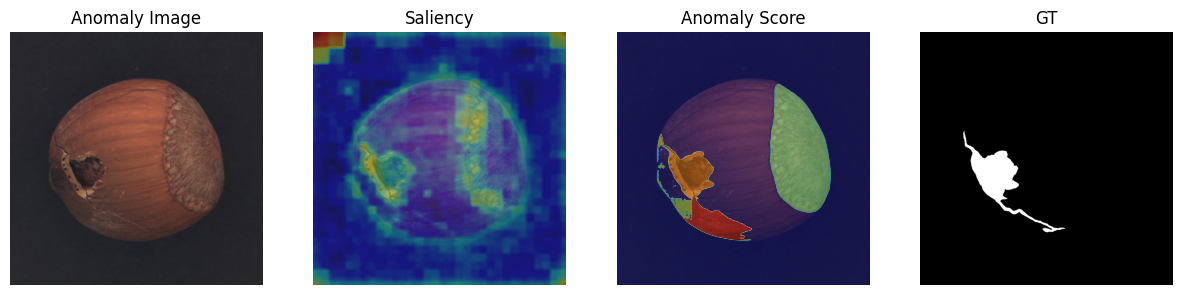

In [208]:
# saa+
textual_prompts = manual_prompts[category]
property_text_prompts =  property_prompts[category]

image = cv2.imread(image_path)
model.set_ensemble_text_prompts(textual_prompts, verbose=False)
model.set_property_text_prompts(property_text_prompts, verbose=False)
score, appendix = model(image)
similarity_map = appendix['similarity_map']

mask_image = cv2.imread(gt_path)
mask_image_show = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
mask_image_show = cv2.resize(mask_image_show, (eval_resolution, eval_resolution))

image_show = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_show = cv2.resize(image_show, (eval_resolution, eval_resolution))
similarity_map = cv2.resize(similarity_map, (eval_resolution, eval_resolution))
score = cv2.resize(score, (eval_resolution, eval_resolution))

saa_mask = score
saa_mask = saa_mask > 0

plt.figure(figsize=(15, 7))
plt.subplot(141)
plt.imshow(image_show)
plt.axis('off') 
plt.title('Anomaly Image')

plt.subplot(142)
plt.imshow(image_show)
plt.imshow(similarity_map, alpha=0.4, cmap='jet')
plt.axis('off') 
plt.title('Saliency')

plt.subplot(143)
plt.imshow(image_show)
plt.imshow(score, alpha=0.4,cmap='jet')
plt.axis('off') 
plt.title('Anomaly Score')

plt.subplot(144)
plt.imshow(mask_image_show)
# plt.imshow(score, alpha=0.3, cmap='jet')
plt.axis('off') 
plt.title('GT')

plt.savefig('./results_image/saa+/saa+_{}_{}_{}.png'.format(category, sub_category, img_num), bbox_inches='tight', pad_inches=0.1)
plt.show()

### 2. naive prompt

In [209]:
filt_w = 0.7
filt_h = 0.7

After filtering: 1 boxes
tensor([[0.5005, 0.5047, 0.6982, 0.6475]])
['defect']


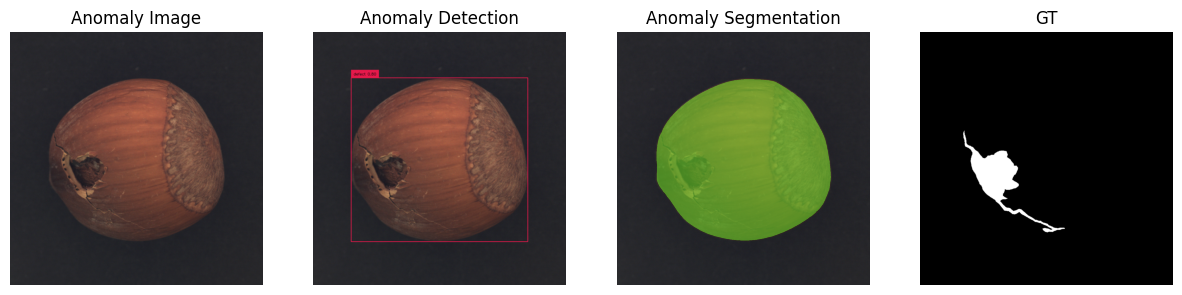

In [210]:
TEXT_PROMPT = "defect"
image_source, image = load_image(image_path)

boxes, logits, phrases = predict(
     model=groundingdino_model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=0.1,
    text_threshold=0.2,
    device=DEVICE)

size = Image.open(image_path).convert("RGB").size
normalized_boxes = boxes.clone()
H, W = size[1], size[0]

for i in range(boxes.size(0)):
    normalized_boxes[i] = normalized_boxes[i] * torch.Tensor([W, H, W, H]).cpu()
    normalized_boxes[i][:2] -= normalized_boxes[i][2:] / 2
    normalized_boxes[i][2:] += normalized_boxes[i][:2]

normalized_boxes = normalized_boxes.cpu()
normalized_logits = logits.to(dtype=normalized_boxes.dtype).cpu() 

indices = ops.nms(normalized_boxes, normalized_logits, iou_threshold = 0.5)
filtered_boxes = []
filtered_logits = []
filtered_pred_phrases = []

for idx in indices:
    box = boxes[idx]
    x, y, w, h = box
    
    if w <= filt_w and h <= filt_h:
        filtered_boxes.append(box)
        filtered_logits.append(logits[idx])
        filtered_pred_phrases.append(phrases[idx])

not_empty_indices = [index for index, value in enumerate(filtered_pred_phrases) if value != '']
filtered_boxes = [filtered_boxes[i] for i in not_empty_indices]
filtered_logits = [filtered_logits[i] for i in not_empty_indices]
filtered_pred_phrases = [filtered_pred_phrases[i] for i in not_empty_indices]

filtered_boxes = torch.stack(filtered_boxes)
filtered_logits = torch.stack(filtered_logits)
print(f"After filtering: {filtered_boxes.shape[0]} boxes")
print(filtered_boxes)
print(filtered_pred_phrases)

annotated_frame = annotate(image_source=image_source, boxes=filtered_boxes, logits=filtered_logits, phrases=filtered_pred_phrases)
annotated_frame = annotated_frame[..., ::-1]  # RGB 변환
annotated_image = Image.fromarray(annotated_frame)
new_size = (600, 600)
resized_image = annotated_image.resize(new_size)
# plt.imshow(annotated_image)

# sam
sam_predictor.set_image(image_source)

# box: normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(filtered_boxes) * torch.Tensor([W, H, W, H])

transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(DEVICE)
masks, _, _ = sam_predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )

naive_mask = sum(masks[i][0] for i in range(len(masks)))
naive_mask = naive_mask > 0 

mask_image = Image.new('RGBA', size, color=(0, 0, 0, 0))
mask_draw = ImageDraw.Draw(mask_image)
for mask in masks:
    draw_mask(mask[0].cpu().numpy(), mask_draw, random_color=True)

plt.figure(figsize=(15, 7))
plt.subplot(141)
plt.imshow(image_show)
plt.axis('off') 
plt.title('Anomaly Image')

plt.subplot(142)
plt.imshow(resized_image)
plt.axis('off') 
plt.title('Anomaly Detection')

plt.subplot(143)
plt.imshow(image_show)
plt.imshow(mask_image)
plt.axis('off') 
plt.title('Anomaly Segmentation')

plt.subplot(144)
plt.imshow(mask_image_show)
plt.axis('off') 
plt.title('GT')

plt.savefig('./results_image/naive/naive_{}_{}_{}.png'.format(category, sub_category, img_num), bbox_inches='tight', pad_inches=0.1)
plt.show()

### 3. RAM prompt

/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied
--------------
./SegmentAnything/weights/ram_swin_large_14m.pth
--------------
load checkpoint from ./SegmentAnything/weights/ram_swin_large_14m.pth
vit: swin_l
Tags:  acorn, chestnut, crack, hazelnut, hole, nut, peel, shell, tear

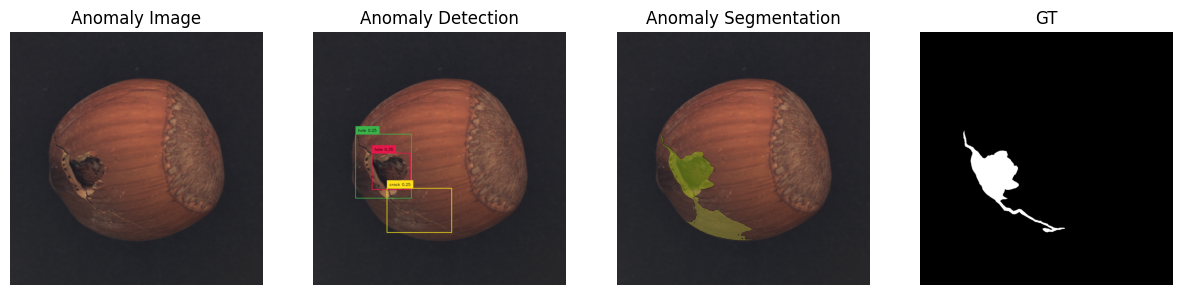

In [211]:
# RAM tag prompt
image_pil = Image.open(image_path).convert("RGB")  # load image

normalize = TS.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
ram_transform = TS.Compose([
    TS.Resize((384, 384)),
    TS.ToTensor(),
    normalize
])

ram_image = image_pil.resize((384, 384))
ram_image = ram_transform(ram_image).unsqueeze(0)
from ram.models import ram_plus, ram
from ram import inference_ram

ram_checkpoint = "./SegmentAnything/weights/ram_swin_large_14m.pth"

ram_model = ram(pretrained=ram_checkpoint, image_size=384, vit='swin_l')
ram_model.eval()
ram_model = ram_model.to(device)

res = inference_ram(ram_image.to(device), ram_model)
tags = res[0].strip(' ').replace('  ', ' ').replace(' |', ',')
print("Tags: ", tags)
# print('RAM finished')

TEXT_PROMPT = tags
image_source, image = load_image(image_path)

# Grounding Dino 모델을 사용하여 이미지에서 객체 감지
boxes, logits, phrases = predict(
    model=groundingdino_model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=0.1,
    text_threshold=0.2,
    device=DEVICE
)

# 이미지의 크기 가져오기
size = Image.open(image_path).convert("RGB").size
normalized_boxes = boxes.clone()
H, W = size[1], size[0]

# 정규화된 상자 좌표를 이미지 크기에 맞게 변경
for i in range(boxes.size(0)):
    normalized_boxes[i] = normalized_boxes[i] * torch.Tensor([W, H, W, H]).cpu()
    normalized_boxes[i][:2] -= normalized_boxes[i][2:] / 2
    normalized_boxes[i][2:] += normalized_boxes[i][:2]

normalized_boxes = normalized_boxes.cpu()
normalized_logits = logits.to(dtype=normalized_boxes.dtype).cpu()

# 비최대 억제(NMS)를 사용하여 겹치는 상자 제거
indices = ops.nms(normalized_boxes, normalized_logits, iou_threshold=0.5)
filtered_boxes = []
filtered_logits = []
filtered_pred_phrases = []

for idx in indices:
    box = boxes[idx]
    x, y, w, h = box

    if w <= filt_w and h <= filt_h:   
        filtered_boxes.append(box)
        filtered_logits.append(logits[idx])
        filtered_pred_phrases.append(phrases[idx])

not_empty_indices = [index for index, value in enumerate(filtered_pred_phrases) if value != '']
filtered_boxes = [filtered_boxes[i] for i in not_empty_indices]
filtered_logits = [filtered_logits[i] for i in not_empty_indices]
filtered_pred_phrases = [filtered_pred_phrases[i] for i in not_empty_indices]

filtered_boxes = torch.stack(filtered_boxes)
filtered_logits = torch.stack(filtered_logits)
print(f"After filtering: {filtered_boxes.shape[0]} boxes")
print(filtered_boxes)
print(filtered_pred_phrases)

# 상자와 레이블을 이미지에 그리기
annotated_frame = annotate(image_source=image_source, boxes=filtered_boxes, logits=filtered_logits, phrases=filtered_pred_phrases)
annotated_frame = annotated_frame[..., ::-1]  # RGB 변환
annotated_image = Image.fromarray(annotated_frame)
new_size = (600, 600)
resized_image = annotated_image.resize(new_size)
# plt.imshow(annotated_image)

# sam
sam_predictor.set_image(image_source)

# box: normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(filtered_boxes) * torch.Tensor([W, H, W, H])

transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(DEVICE)
masks, _, _ = sam_predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )

ram_mask = sum(masks[i][0] for i in range(len(masks)))
ram_mask = ram_mask > 0

mask_image = Image.new('RGBA', size, color=(0, 0, 0, 0))
mask_draw = ImageDraw.Draw(mask_image)
for mask in masks:
    draw_mask(mask[0].cpu().numpy(), mask_draw, random_color=True)

plt.figure(figsize=(15, 7))
plt.subplot(141)
plt.imshow(image_show)
plt.axis('off') 
plt.title('Anomaly Image')

plt.subplot(142)
plt.imshow(resized_image)
plt.axis('off') 
plt.title('Anomaly Detection')

plt.subplot(143)
plt.imshow(image_show)
plt.imshow(mask_image)
plt.axis('off') 
plt.title('Anomaly Segmentation')

plt.subplot(144)
plt.imshow(mask_image_show)
plt.axis('off') 
plt.title('GT')

plt.savefig('./results_image/ram/ram_{}_{}_{}.png'.format(category, sub_category, img_num), bbox_inches='tight', pad_inches=0.1)
plt.show()

### 4. RAM + BB

In [212]:
filt_bb = 1.5

After filtering: 3 boxes
tensor([[0.3094, 0.5509, 0.1516, 0.1435],
        [0.2788, 0.5299, 0.2215, 0.2530],
        [0.4205, 0.7051, 0.2566, 0.1754]])
['hole', 'hole', 'crack']
1.5 * boxes:  tensor([[0.3094, 0.5509, 0.2274, 0.2153],
        [0.2788, 0.5299, 0.3322, 0.3795],
        [0.4205, 0.7051, 0.3849, 0.2630]])


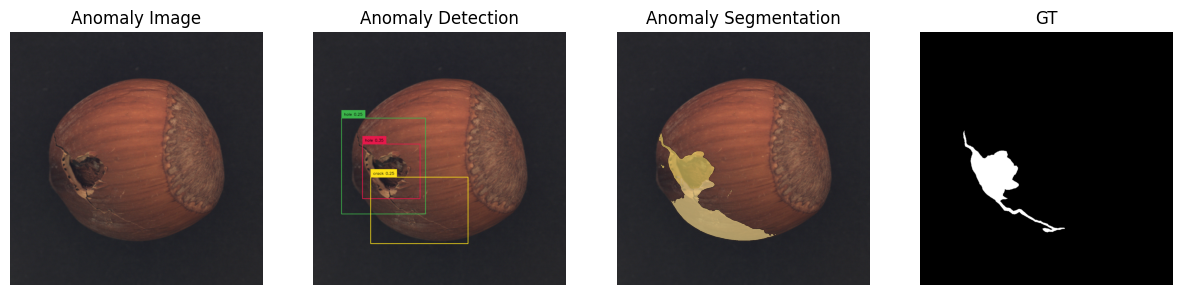

In [213]:
# * Bounding Box
TEXT_PROMPT = tags
image_source, image = load_image(image_path)

# Grounding Dino 모델을 사용하여 이미지에서 객체 감지
boxes, logits, phrases = predict(
    model=groundingdino_model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=0.1,
    text_threshold=0.2,
    device=DEVICE
)

# 이미지의 크기 가져오기
size = Image.open(image_path).convert("RGB").size
normalized_boxes = boxes.clone()
H, W = size[1], size[0]

# 정규화된 상자 좌표를 이미지 크기에 맞게 변경
for i in range(boxes.size(0)):
    normalized_boxes[i] = normalized_boxes[i] * torch.Tensor([W, H, W, H]).cpu()
    normalized_boxes[i][:2] -= normalized_boxes[i][2:] / 2
    normalized_boxes[i][2:] += normalized_boxes[i][:2]

normalized_boxes = normalized_boxes.cpu()
normalized_logits = logits.to(dtype=normalized_boxes.dtype).cpu()

# 비최대 억제(NMS)를 사용하여 겹치는 상자 제거
indices = ops.nms(normalized_boxes, normalized_logits, iou_threshold=0.5)
filtered_boxes = []
filtered_logits = []
filtered_pred_phrases = []

for idx in indices:
    box = boxes[idx]
    x, y, w, h = box

    if w <= filt_w and h <= filt_h:   
        filtered_boxes.append(box)
        filtered_logits.append(logits[idx])
        filtered_pred_phrases.append(phrases[idx])

not_empty_indices = [index for index, value in enumerate(filtered_pred_phrases) if value != '']
filtered_boxes = [filtered_boxes[i] for i in not_empty_indices]
filtered_logits = [filtered_logits[i] for i in not_empty_indices]
filtered_pred_phrases = [filtered_pred_phrases[i] for i in not_empty_indices]

filtered_boxes = torch.stack(filtered_boxes)
filtered_logits = torch.stack(filtered_logits)
print(f"After filtering: {filtered_boxes.shape[0]} boxes")
print(filtered_boxes)
print(filtered_pred_phrases)

filtered_boxes[:, 2] = filtered_boxes[:, 2] * filt_bb
filtered_boxes[:, 3] = filtered_boxes[:, 3] * filt_bb
print('{} * boxes: '.format(filt_bb) , filtered_boxes)

# 상자와 레이블을 이미지에 그리기
annotated_frame = annotate(image_source=image_source, boxes=filtered_boxes, logits=filtered_logits, phrases=filtered_pred_phrases)
annotated_frame = annotated_frame[..., ::-1]  # RGB 변환
annotated_image = Image.fromarray(annotated_frame)
new_size = (600, 600)
resized_image = annotated_image.resize(new_size)
# plt.imshow(annotated_image)

# sam
sam_predictor.set_image(image_source)

# box: normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(filtered_boxes) * torch.Tensor([W, H, W, H])

transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(DEVICE)
masks, _, _ = sam_predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )

ram_bb_mask = sum(masks[i][0] for i in range(len(masks)))
ram_bb_mask = ram_bb_mask > 0

mask_image = Image.new('RGBA', size, color=(0, 0, 0, 0))
mask_draw = ImageDraw.Draw(mask_image)
for mask in masks:
    draw_mask(mask[0].cpu().numpy(), mask_draw, random_color=True)

plt.figure(figsize=(15, 7))
plt.subplot(141)
plt.imshow(image_show)
plt.axis('off') 
plt.title('Anomaly Image')

plt.subplot(142)
plt.imshow(resized_image)
plt.axis('off') 
plt.title('Anomaly Detection')

plt.subplot(143)
plt.imshow(image_show)
plt.imshow(mask_image)
plt.axis('off') 
plt.title('Anomaly Segmentation')

plt.subplot(144)
plt.imshow(mask_image_show)
plt.axis('off') 
plt.title('GT')

plt.savefig('./results_image/ram+bb/ram_bb_{}_{}_{}.png'.format(category, sub_category, img_num), bbox_inches='tight', pad_inches=0.1)
plt.show()


### 5. RAM + BB +IPA

In [214]:
diff_threshold = 15

100%|██████████| 50/50 [00:01<00:00, 28.09it/s]


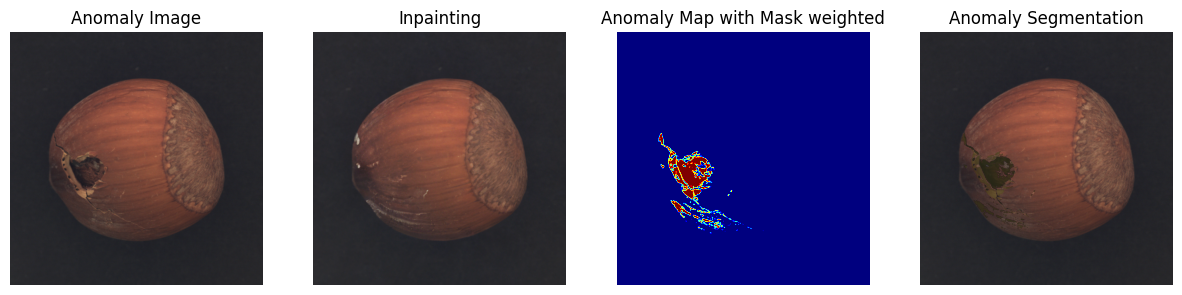

In [215]:
# inpainting
prompt = category
image_mask = ram_bb_mask.cpu().numpy()

image_source_pil = Image.fromarray(image_source)
annotated_frame_pil = Image.fromarray(annotated_frame)
image_mask_pil = Image.fromarray(image_mask)
annotated_frame_with_mask_pil = Image.fromarray(show_mask(ram_bb_mask, annotated_frame))

image_source_for_inpaint = image_source_pil.resize((512, 512))
image_mask_for_inpaint = image_mask_pil.resize((512, 512))
image_inpainting = pipe(prompt=prompt, image=image_source_for_inpaint, mask_image=image_mask_for_inpaint).images[0]
image_inpainting = image_inpainting.resize((image_source_pil.size[0], image_source_pil.size[1]))

ipa_path = "./results_image/inpainting/ram_bb_ipa_{}_{}_{}.png".format(category, sub_category, img_num)
image_inpainting.save(ipa_path)

original_image = cv2.imread(image_path)
inpainted_image = cv2.imread(ipa_path)

diff_image = cv2.absdiff(original_image, inpainted_image)
diff_gray = cv2.cvtColor(diff_image, cv2.COLOR_BGR2GRAY)

anomaly_map_1 = np.where(diff_gray > diff_threshold, 255, 0)
anomaly_map_2 = np.where(image_mask, anomaly_map_1, 0)

ram_bb_ipa_mask = anomaly_map_2
ram_bb_ipa_mask = ram_bb_ipa_mask > 0

mask_image = Image.new('RGBA', size, color=(0, 0, 0, 0))
mask_draw = ImageDraw.Draw(mask_image)
draw_mask(ram_bb_ipa_mask, mask_draw, random_color=True)

plt.figure(figsize=(15, 7))
plt.subplot(141)
image_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off') 
plt.title('Anomaly Image')

plt.subplot(142)
plt.imshow(image_inpainting)
plt.axis('off') 
plt.title('Inpainting')

plt.subplot(143)
plt.imshow(image_show)
plt.imshow(anomaly_map_2, cmap='jet')
plt.axis('off') 
plt.title('Anomaly Map with Mask weighted')

plt.subplot(144)
plt.imshow(image_show)
plt.imshow(mask_image)
plt.axis('off') 
plt.title('Anomaly Segmentation')

# plt.subplot(143)
# #plt.imshow(image_show)
# plt.imshow(anomaly_map_1, cmap='jet')
# plt.axis('off') 
# plt.title('Anomaly Map')

plt.savefig('./results_image/ram+bb+ipa/ram_bb_ipa{}_{}_{}.png'.format(category, sub_category, img_num), bbox_inches='tight', pad_inches=0.1)
plt.show()

### 6. RAM + LLM + BB

In [199]:
llama_tags = 'abnormal acorn, abnormal chestnut, crack, abnormal hazelnut, hole, abnormal nut, peel defect, shell defect, tear'

After filtering: 2 boxes
tensor([[0.2899, 0.1906, 0.0380, 0.0353],
        [0.2670, 0.2094, 0.0884, 0.0738]])
['loose screw', 'screw']
1.5 * boxes:  tensor([[0.2899, 0.1906, 0.0570, 0.0530],
        [0.2670, 0.2094, 0.1325, 0.1107]])


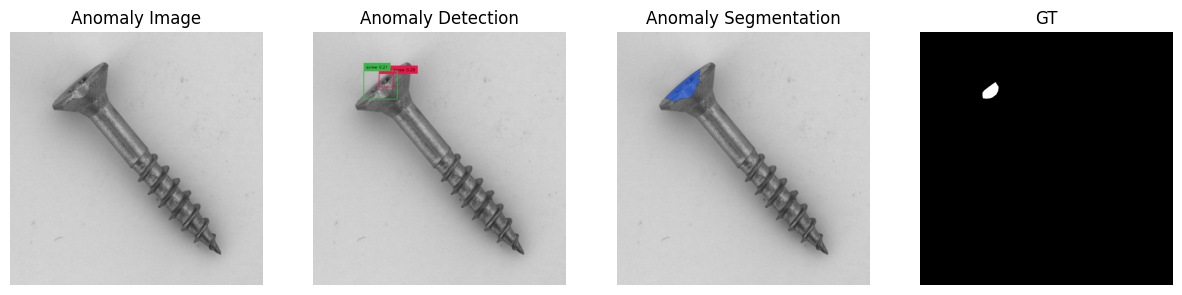

In [200]:
# llamma
TEXT_PROMPT = llama_tags
image_source, image = load_image(image_path)

# Grounding Dino 모델을 사용하여 이미지에서 객체 감지
boxes, logits, phrases = predict(
    model=groundingdino_model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=0.1,
    text_threshold=0.2,
    device=DEVICE
)

# 이미지의 크기 가져오기
size = Image.open(image_path).convert("RGB").size
normalized_boxes = boxes.clone()
H, W = size[1], size[0]

# 정규화된 상자 좌표를 이미지 크기에 맞게 변경
for i in range(boxes.size(0)):
    normalized_boxes[i] = normalized_boxes[i] * torch.Tensor([W, H, W, H]).cpu()
    normalized_boxes[i][:2] -= normalized_boxes[i][2:] / 2
    normalized_boxes[i][2:] += normalized_boxes[i][:2]

normalized_boxes = normalized_boxes.cpu()
normalized_logits = logits.to(dtype=normalized_boxes.dtype).cpu()

# 비최대 억제(NMS)를 사용하여 겹치는 상자 제거
indices = ops.nms(normalized_boxes, normalized_logits, iou_threshold=0.5)
filtered_boxes = []
filtered_logits = []
filtered_pred_phrases = []

for idx in indices:
    box = boxes[idx]
    x, y, w, h = box

    if w <= filt_w and h <= filt_h:   
        filtered_boxes.append(box)
        filtered_logits.append(logits[idx])
        filtered_pred_phrases.append(phrases[idx])

not_empty_indices = [index for index, value in enumerate(filtered_pred_phrases) if value != '']
filtered_boxes = [filtered_boxes[i] for i in not_empty_indices]
filtered_logits = [filtered_logits[i] for i in not_empty_indices]
filtered_pred_phrases = [filtered_pred_phrases[i] for i in not_empty_indices]

filtered_boxes = torch.stack(filtered_boxes)
filtered_logits = torch.stack(filtered_logits)
print(f"After filtering: {filtered_boxes.shape[0]} boxes")
print(filtered_boxes)
print(filtered_pred_phrases)

filtered_boxes[:, 2] = filtered_boxes[:, 2] * filt_bb
filtered_boxes[:, 3] = filtered_boxes[:, 3] * filt_bb
print('{} * boxes: '.format(filt_bb) , filtered_boxes)

# 상자와 레이블을 이미지에 그리기
annotated_frame = annotate(image_source=image_source, boxes=filtered_boxes, logits=filtered_logits, phrases=filtered_pred_phrases)
annotated_frame = annotated_frame[..., ::-1]  # RGB 변환
annotated_image = Image.fromarray(annotated_frame)
new_size = (600, 600)
resized_image = annotated_image.resize(new_size)
# plt.imshow(annotated_image)

# sam
sam_predictor.set_image(image_source)

# box: normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(filtered_boxes) * torch.Tensor([W, H, W, H])

transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(DEVICE)
masks, _, _ = sam_predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )

ram_llm_bb_mask = sum(masks[i][0] for i in range(len(masks)))
ram_llm_bb_mask = ram_llm_bb_mask > 0

mask_image = Image.new('RGBA', size, color=(0, 0, 0, 0))
mask_draw = ImageDraw.Draw(mask_image)
for mask in masks:
    draw_mask(mask[0].cpu().numpy(), mask_draw, random_color=True)

plt.figure(figsize=(15, 7))
plt.subplot(141)
plt.imshow(image_show)
plt.axis('off') 
plt.title('Anomaly Image')

plt.subplot(142)
plt.imshow(resized_image)
plt.axis('off') 
plt.title('Anomaly Detection')

plt.subplot(143)
plt.imshow(image_show)
plt.imshow(mask_image)
plt.axis('off') 
plt.title('Anomaly Segmentation')

plt.subplot(144)
plt.imshow(mask_image_show)
plt.axis('off') 
plt.title('GT')

plt.savefig('./results_image/ram+llm+bb/ram_llm_bb_{}_{}_{}.png'.format(category, sub_category, img_num), bbox_inches='tight', pad_inches=0.1)
plt.show()


### 7. RAM + LLM + BB + IPA

100%|██████████| 50/50 [00:01<00:00, 25.05it/s]


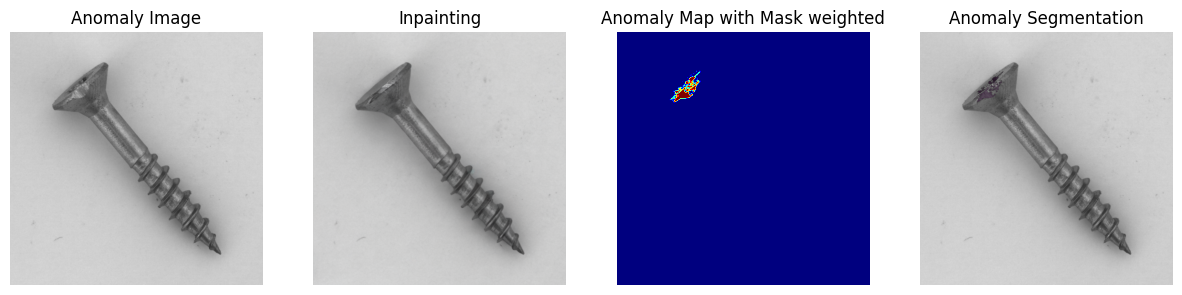

In [204]:
# inpainting
prompt = category
image_mask = ram_llm_bb_mask.cpu().numpy()

image_source_pil = Image.fromarray(image_source)
annotated_frame_pil = Image.fromarray(annotated_frame)
image_mask_pil = Image.fromarray(image_mask)
annotated_frame_with_mask_pil = Image.fromarray(show_mask(ram_llm_bb_mask, annotated_frame))

image_source_for_inpaint = image_source_pil.resize((512, 512))
image_mask_for_inpaint = image_mask_pil.resize((512, 512))
image_inpainting = pipe(prompt=prompt, image=image_source_for_inpaint, mask_image=image_mask_for_inpaint).images[0]
image_inpainting = image_inpainting.resize((image_source_pil.size[0], image_source_pil.size[1]))

ipa_path = "./results_image/inpainting/ram_llm_bb_ipa_{}_{}_{}.png".format(category, sub_category, img_num)
image_inpainting.save(ipa_path)

original_image = cv2.imread(image_path)
inpainted_image = cv2.imread(ipa_path)

diff_image = cv2.absdiff(original_image, inpainted_image)
diff_gray = cv2.cvtColor(diff_image, cv2.COLOR_BGR2GRAY)

anomaly_map_1 = np.where(diff_gray > diff_threshold, 255, 0)
anomaly_map_2 = np.where(image_mask, anomaly_map_1, 0)

ram_llm_bb_ipa_mask = anomaly_map_2
ram_llm_bb_ipa_mask = ram_llm_bb_ipa_mask > 0

mask_image = Image.new('RGBA', size, color=(0, 0, 0, 0))
mask_draw = ImageDraw.Draw(mask_image)
draw_mask(ram_llm_bb_ipa_mask, mask_draw, random_color=True)

plt.figure(figsize=(15, 7))
plt.subplot(141)
image_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off') 
plt.title('Anomaly Image')

plt.subplot(142)
plt.imshow(image_inpainting)
plt.axis('off') 
plt.title('Inpainting')

plt.subplot(143)
plt.imshow(image_show)
plt.imshow(anomaly_map_2, cmap='jet')
plt.axis('off') 
plt.title('Anomaly Map with Mask weighted')

plt.subplot(144)
plt.imshow(image_show)
plt.imshow(mask_image)
plt.axis('off') 
plt.title('Anomaly Segmentation')

# plt.subplot(143)
# #plt.imshow(image_show)
# plt.imshow(anomaly_map_1, cmap='jet')
# plt.axis('off') 
# plt.title('Anomaly Map')

plt.savefig('./results_image/ram+llm+bb+ipa/ram_llm_bb_ipa{}_{}_{}.png'.format(category, sub_category, img_num), bbox_inches='tight', pad_inches=0.1)
plt.show()

### 8. Compare

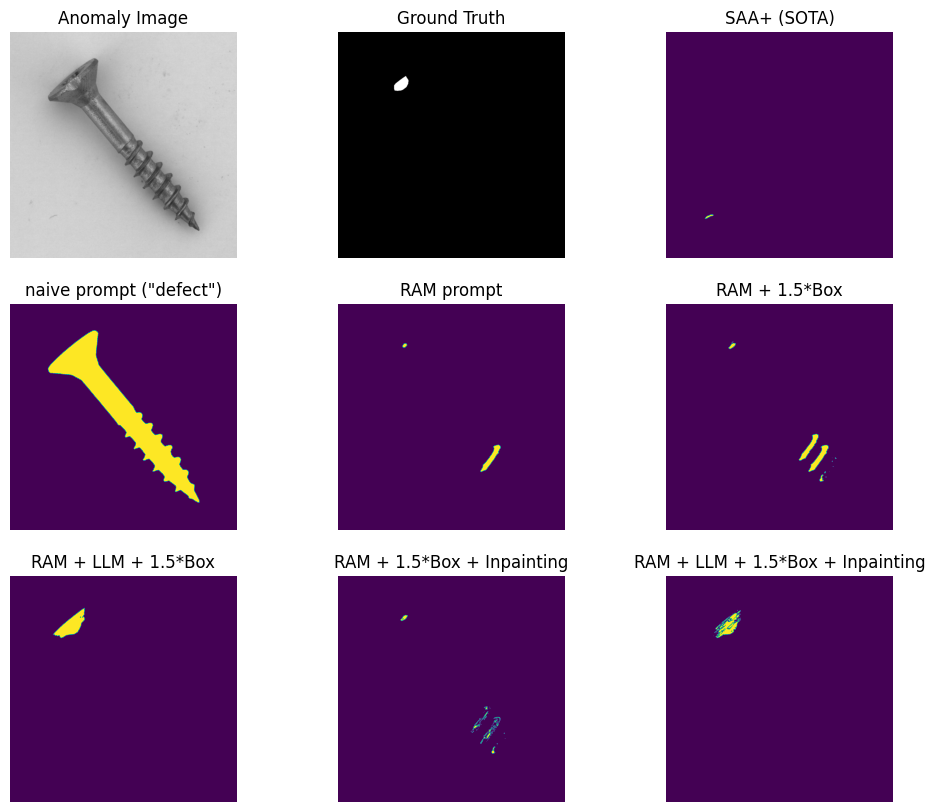

In [202]:
plt.figure(figsize=(12, 10))
plt.subplot(331)
plt.imshow(image_show)
plt.axis('off') 
plt.title('Anomaly Image')

plt.subplot(332)
plt.imshow(mask_image_show)
plt.axis('off') 
plt.title('Ground Truth')

plt.subplot(333)
plt.imshow(saa_mask)
plt.axis('off') 
plt.title('SAA+ (SOTA)')

plt.subplot(334)
plt.imshow(naive_mask.cpu().numpy())
plt.axis('off') 
plt.title('naive prompt ("defect")')

plt.subplot(335)
plt.imshow(ram_mask.cpu().numpy())
plt.axis('off') 
plt.title('RAM prompt')

plt.subplot(336)
plt.imshow(ram_bb_mask.cpu().numpy())
plt.axis('off') 
plt.title('RAM + 1.5*Box')

plt.subplot(337)
plt.imshow(ram_llm_bb_mask.cpu().numpy())
plt.axis('off') 
plt.title('RAM + LLM + 1.5*Box')

plt.subplot(338)
plt.imshow(ram_bb_ipa_mask)
plt.axis('off') 
plt.title('RAM + 1.5*Box + Inpainting')

plt.subplot(339)
plt.imshow(ram_llm_bb_ipa_mask)
plt.axis('off') 
plt.title('RAM + LLM + 1.5*Box + Inpainting')

plt.savefig('./results_image/compare/compare_{}_{}_{}.png'.format(category, sub_category, img_num), bbox_inches='tight', pad_inches=0.1)
plt.show()

In [64]:
# 마스크를 1.5배로 리사이즈하는 함수
def resize_mask(mask, scale_factor):
    # 텐서를 numpy 배열로 변환
    mask_np = mask.cpu().numpy()
    # 현재 크기
    original_height, original_width = mask_np.shape
    # 새로운 크기 계산
    new_height = int(original_height * scale_factor)
    new_width = int(original_width * scale_factor)
    # 리사이즈
    resized_mask_np = cv2.resize(mask_np, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
    # 다시 텐서로 변환
    resized_mask = torch.tensor(resized_mask_np)
    return resized_mask

# 최종 마스크의 크기를 1.5배로 리사이즈
scale_factor = 1.5
resized_last_mask = resize_mask(ram_bb_mask, scale_factor)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src data type = bool is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


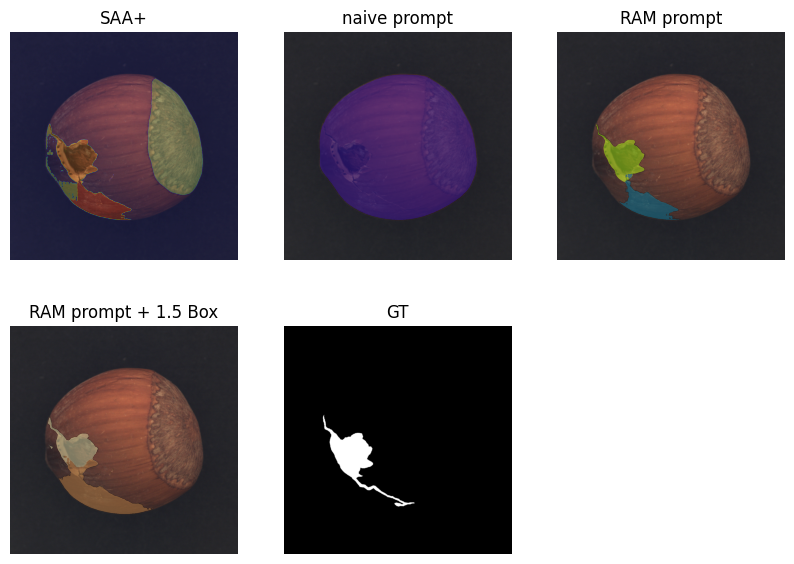

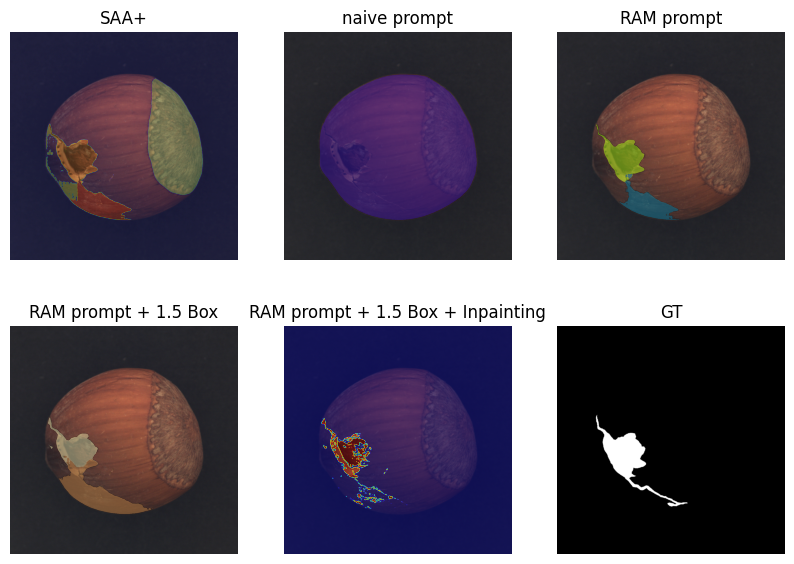

In [73]:
plt.figure(figsize=(10, 7))
plt.subplot(231)
plt.imshow(image_show)
plt.imshow(saa_mask, alpha=0.2,cmap='jet')
plt.axis('off') 
plt.title('SAA+')

plt.subplot(232)
plt.imshow(image_show)
plt.imshow(naive_mask)
plt.axis('off') 
plt.title('naive prompt')

plt.subplot(233)
plt.imshow(image_show)
plt.imshow(ram_mask)
plt.axis('off') 
plt.title('RAM prompt')

plt.subplot(234)
plt.imshow(image_show)
plt.imshow(ram_plus_mask)
plt.axis('off') 
plt.title('RAM prompt + 1.5 Box')

plt.subplot(235)
plt.imshow(image_rgb)
plt.imshow(anomaly_map_2, alpha= 0.5, cmap='jet')
plt.axis('off') 
plt.title('RAM prompt + 1.5 Box + Inpainting')

plt.subplot(236)
plt.imshow(mask_image_show)
plt.axis('off') 
plt.title('GT')
plt.show()